In [1]:
from __future__ import print_function
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
from tensorflow.keras import optimizers

In [2]:
# Blas GEMM launch failed , avoiding the problems when distributing GPU/CPU dynamically
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


In [4]:
batch_size = 32
num_classes = 10
epochs = 20
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [5]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

In [7]:
print("Total Parameters：%d" % model.count_params())

Total Parameters：1250858


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1

In [9]:
# SGD
opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [10]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [11]:
if not data_augmentation:
    print('Not using data augmentation.')
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    print('')
        
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 7s 130us/sample - loss: 1.7363 - accuracy: 0.3603 - val_loss: 1.3564 - val_accuracy: 0.5040
Epoch 2/20
50000/50000 [==============================] - 5s 100us/sample - loss: 1.3064 - accuracy: 0.5292 - val_loss: 1.0906 - val_accuracy: 0.6174
Epoch 3/20
50000/50000 [==============================] - 5s 103us/sample - loss: 1.1397 - accuracy: 0.5964 - val_loss: 1.0199 - val_accuracy: 0.6402
Epoch 4/20
50000/50000 [==============================] - 5s 103us/sample - loss: 1.0185 - accuracy: 0.6421 - val_loss: 0.8742 - val_accuracy: 0.6909
Epoch 5/20
50000/50000 [==============================] - 5s 105us/sample - loss: 0.9477 - accuracy: 0.6675 - val_loss: 0.8368 - val_accuracy: 0.7036
Epoch 6/20
50000/50000 [==============================] - 5s 106us/sample - loss: 0.8931 - accuracy: 0.6862 - val_loss: 0.8348 - val_accuracy: 0.7151
Epoch 7/20
500

In [12]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Saved trained model at /home/ginger/saved_models/keras_cifar10_trained_model.h5 
10000/1 [==============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test loss: 0.6897875172615051
Test accuracy: 0.7664


In [13]:
import numpy 

print ( " test set " )
scores = model.evaluate(x_test,y_test,batch_size=200,verbose= 0)
print ( "" )
#print ( " The test loss is %f " % scores)
print ( " The test loss is %f ", scores)

result = model.predict(x_test,batch_size=200,verbose= 0)

result_max = numpy.argmax(result, axis = 1 )
test_max = numpy.argmax(y_test, axis = 1 )

result_bool = numpy.equal(result_max, test_max)
true_num = numpy.sum(result_bool)

 test set 

 The test loss is %f  [0.6897875344753266, 0.7664]


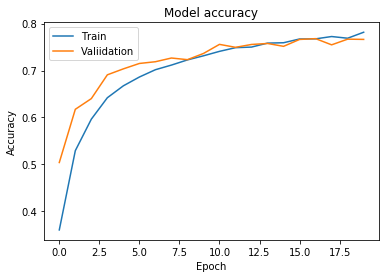

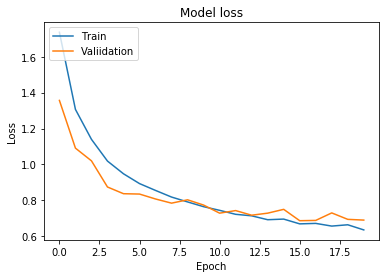

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()

In [16]:
# Adam
opt = optimizers.Adam(lr=0.1)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [17]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [18]:
if not data_augmentation:
    print('Not using data augmentation.')
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    print('')
        
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 6s 114us/sample - loss: 3.7918 - accuracy: 0.0994 - val_loss: 2.3144 - val_accuracy: 0.1000
Epoch 2/20
50000/50000 [==============================] - 5s 104us/sample - loss: 2.3157 - accuracy: 0.1002 - val_loss: 2.3121 - val_accuracy: 0.1000
Epoch 3/20
50000/50000 [==============================] - 5s 104us/sample - loss: 2.3153 - accuracy: 0.1004 - val_loss: 2.3146 - val_accuracy: 0.1000
Epoch 4/20
50000/50000 [==============================] - 5s 106us/sample - loss: 2.3169 - accuracy: 0.0967 - val_loss: 2.3143 - val_accuracy: 0.1000
Epoch 5/20
50000/50000 [==============================] - 5s 108us/sample - loss: 2.3152 - accuracy: 0.0975 - val_loss: 2.3228 - val_accuracy: 0.1000
Epoch 6/20
50000/50000 [==============================] - 5s 109us/sample - loss: 2.3149 - accuracy: 0.1006 - val_loss: 2.3110 - val_accuracy: 0.1000
Epoch 7/20
500

In [19]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Saved trained model at /home/ginger/saved_models/keras_cifar10_trained_model.h5 
10000/1 [==============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test loss: 2.3138977138519286
Test accuracy: 0.1


In [20]:
import numpy 

print ( " test set " )
scores = model.evaluate(x_test,y_test,batch_size=200,verbose= 0)
print ( "" )
#print ( " The test loss is %f " % scores)
print ( " The test loss is %f ", scores)

result = model.predict(x_test,batch_size=200,verbose= 0)

result_max = numpy.argmax(result, axis = 1 )
test_max = numpy.argmax(y_test, axis = 1 )

result_bool = numpy.equal(result_max, test_max)
true_num = numpy.sum(result_bool)

 test set 

 The test loss is %f  [2.313897728919983, 0.1]


In [21]:
batch_size = 128
num_classes = 10
epochs = 10
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [22]:
# Adam (adjust batch size and epoch)
opt = optimizers.SGD(lr=0.01)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [23]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [24]:
if not data_augmentation:
    print('Not using data augmentation.')
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    print('')
        
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 3s 65us/sample - loss: 2.3106 - accuracy: 0.1000 - val_loss: 2.3079 - val_accuracy: 0.1000
Epoch 2/10
50000/50000 [==============================] - 3s 53us/sample - loss: 2.3064 - accuracy: 0.1000 - val_loss: 2.3051 - val_accuracy: 0.1000
Epoch 3/10
50000/50000 [==============================] - 3s 54us/sample - loss: 2.3044 - accuracy: 0.1000 - val_loss: 2.3038 - val_accuracy: 0.1000
Epoch 4/10
50000/50000 [==============================] - 3s 54us/sample - loss: 2.3034 - accuracy: 0.1000 - val_loss: 2.3031 - val_accuracy: 0.1000
Epoch 5/10
50000/50000 [==============================] - 3s 55us/sample - loss: 2.3030 - accuracy: 0.1000 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 6/10
50000/50000 [==============================] - 3s 55us/sample - loss: 2.3028 - accuracy: 0.0996 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 7/10
50000/500

In [25]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Saved trained model at /home/ginger/saved_models/keras_cifar10_trained_model.h5 
10000/1 [==============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test loss: 2.302591390609741
Test accuracy: 0.1


In [26]:
import numpy 

print ( " test set " )
scores = model.evaluate(x_test,y_test,batch_size=200,verbose= 0)
print ( "" )
#print ( " The test loss is %f " % scores)
print ( " The test loss is %f ", scores)

result = model.predict(x_test,batch_size=200,verbose= 0)

result_max = numpy.argmax(result, axis = 1 )
test_max = numpy.argmax(y_test, axis = 1 )

result_bool = numpy.equal(result_max, test_max)
true_num = numpy.sum(result_bool)

 test set 

 The test loss is %f  [2.3025914001464844, 0.1]


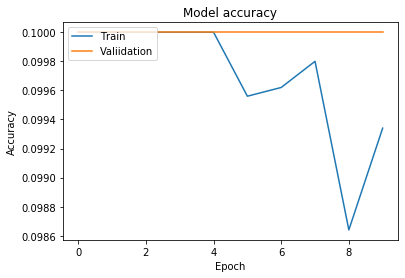

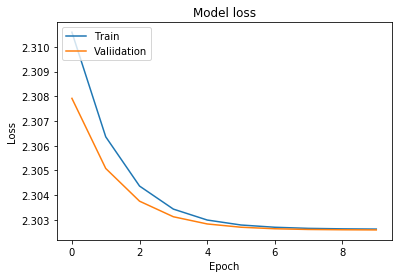

In [27]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()

In [28]:
batch_size = 32
num_classes = 10
epochs = 20
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [29]:
# Rmsprop
opt = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [30]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [31]:
if not data_augmentation:
    print('Not using data augmentation.')
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    print('')
        
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 6s 114us/sample - loss: 2.3033 - accuracy: 0.0979 - val_loss: 2.3034 - val_accuracy: 0.1000
Epoch 2/20
50000/50000 [==============================] - 5s 106us/sample - loss: 2.3031 - accuracy: 0.1028 - val_loss: 2.3036 - val_accuracy: 0.1000
Epoch 3/20
50000/50000 [==============================] - 5s 108us/sample - loss: 2.3035 - accuracy: 0.0992 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 4/20
50000/50000 [==============================] - 6s 116us/sample - loss: 2.3034 - accuracy: 0.0974 - val_loss: 2.3036 - val_accuracy: 0.1000
Epoch 5/20
50000/50000 [==============================] - 6s 111us/sample - loss: 2.3035 - accuracy: 0.0970 - val_loss: 2.3031 - val_accuracy: 0.1000
Epoch 6/20
50000/50000 [==============================] - 5s 109us/sample - loss: 2.3034 - accuracy: 0.0987 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 7/20
500

In [32]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Saved trained model at /home/ginger/saved_models/keras_cifar10_trained_model.h5 
10000/1 [==============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test loss: 2.302850468444824
Test accuracy: 0.1


In [33]:
import numpy 

print ( " test set " )
scores = model.evaluate(x_test,y_test,batch_size=200,verbose= 0)
print ( "" )
#print ( " The test loss is %f " % scores)
print ( " The test loss is %f ", scores)

result = model.predict(x_test,batch_size=200,verbose= 0)

result_max = numpy.argmax(result, axis = 1 )
test_max = numpy.argmax(y_test, axis = 1 )

result_bool = numpy.equal(result_max, test_max)
true_num = numpy.sum(result_bool)

 test set 

 The test loss is %f  [2.3028504848480225, 0.1]
